In [ ]:
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

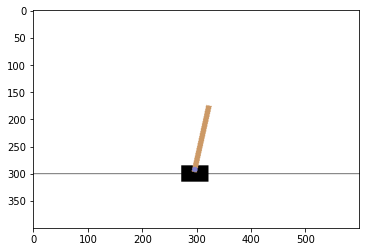

In [ ]:
env = gym.make("CartPole-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close()

Summary of information
---
Actions are a series of 1 and 0. Observation gives us 4 variables, cart, velocity of cart, angle of pole, rotation rate of pole


In [ ]:
from collections import namedtuple, deque
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from itertools import count
import random
import math
import matplotlib
import matplotlib.pyplot as plt


is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
#Create tuple that contains the transisition from one enviorment to another.
#It maps the state and action to the reuslt which is the next state and the reward.


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)
        #

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [ ]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)

def get_screen():
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    screen = screen[:, :, slice_range]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0)
    #We use a rendered image to obtain our state in the program. The program 
    #returns a patch of the enviroment that is centered on the cart. All
    #surrounding pixels are cropped our of the final returned patch. 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
#The probability of choosing a randome action is based on the EPS_Start.
#This values begins to decay and head towards EPS_END. This rate of decay is 
#determined by EPS_DECAY. 

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

n_actions = env.action_space.n
#We retrive the total number of possible actions that we can take and
#initialize it into n_actions. In this case there are only two possible 
#actions, left and right. 
policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
  #We determine the action to take based on the epsilon greddy policy. 
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
            #We have two possible actions that we can take, left and right. The 
            #program returns the action that gives the maximum expected reward.
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    display.clear_output(wait=True)

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    #We transpose the batch, and convert it to a Transition of batch-array.
    
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    # The program computes V(S{t+1}) for all next states. We obtain values of actions
    # that don't terminate the program. The program selects the highest reward. 
    # We then obtain a value of 0 if the program termianted or the expected values
    # of the state. 

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    #The program then computed gthe Huberloss which is used in robust regression. 
    #This method is less sensetive to outliers. 

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

An agent trained for a short amount of time.

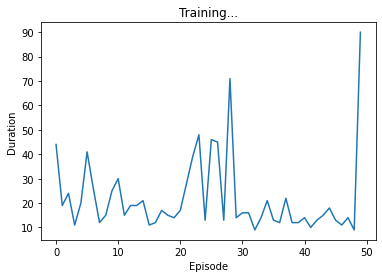

Complete


In [ ]:
num_episodes = 50
#We set the number of trials that the agent trains to 50 to represent an 
#for an agent trained for a short time. Increasing the number of episodes would
#result in better results and the model would have a longer duration per episode. 
for i_episode in range(num_episodes):
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    #The state is determined by taking the difference between the current 
    #and last state. Both screens are defines as tensors.  
    for t in count():
        action = select_action(state)
        #The agent selects an actions based on the two possible actions,
        #left and right. The agent selects the action that maxmiums the 
        #return on reward. 
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
            #When the program takes an action and the model
            #doesn't fail, we initilize the next state. We take the difference
            #of the previous screen patch and the new screen patch after the
            #the action is taken. 
        else:
            next_state = None
            #When the program randomly take an action and the model fails, we
            #initlize the next state. Since the program termianted we set the
            #state to none, beacuse there are no further states after that. 
            
        memory.push(state, action, next_state, reward)
        state = next_state
        #Once the program takes an action, and the program doesn't termainate, 
        #we replace the current state with the next state.

        optimize_model()
        #Once an action we taken we optimize the policy once.  
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            plt.show()
            break
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    #Once an action is taken we update the network such that the DQN
    #contains the new wights and biases. 
plt.show()
print('Complete')


An agent trained for a long amount of time.

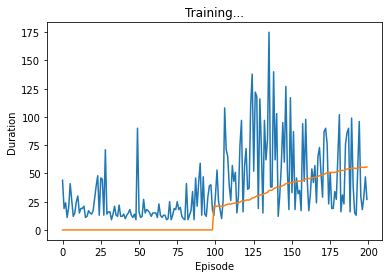

Complete


In [ ]:
num_episodes = 150
for i_episode in range(num_episodes):
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
        memory.push(state, action, next_state, reward)
        state = next_state

        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            plt.show()
            plt.close('all')
            break
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
print('Complete')

In [ ]:
torch.cuda.empty_cache()
plt.close('all')

Random Agent

In [ ]:
def plot_durations2():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    c = durations_t.numpy()
    plt.plot(c[200:250])
    display.clear_output(wait=True)

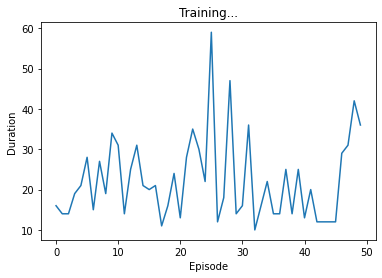

Complete


In [ ]:
from torch import randint
num_episodes = 200
#We set the number of trials that the agent trains to 200 to represent an 
#for a randome agent.
for i_episode in range(num_episodes):
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    #The state is determined by taking the difference between the current 
    #and last state. 
    for t in count():
        action = randint(0,env.action_space.n,(1,))
        #The agent randomly selects an action to take out of the avlaible 
        #option left and right. 
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
            #When the program randomly takes an action and the model
            #doesn't fail, we initilize the next state. We take the difference
            #of the previous screen patch and the new screen patch after the
            #the action is taken. 
    
        else:
            next_state = None
            #When the program randomly take an action and the model fails, we
            #initlize the next state. Since the program termianted we set the
            #state to none, beacuse there are no further states after that. 
        memory.push(state, action, next_state, reward)
        state = next_state
        #Once the program takes an action, and the program doesn't termainate, 
        #we replace the current state with the next state. 

        if done:
            episode_durations.append(t + 1)
            plt.close('all')
            plot_durations2()
            #The main loop plots the duration of each episode on a graph, 
            #episodes vs duration. 
            plt.show()
            break
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
plt.show()
print('Complete')